In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import re
import pickle
from tqdm import tqdm
import os

from collections import Counter

<h1>1. K Nearest Neighbor</h1>

## 1.1 Loading Data

In [2]:
data  = pd.read_csv('preprocessed_data.csv', nrows=5000)
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [3]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(2)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [4]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [5]:
ex = ["classroom students should take break",
"low income homes students receive free breakfast",
"students will receive low grades"]
vectorizer = CountVectorizer()
vectorizer.fit(ex)
print(vectorizer.transform(ex).toarray())
print(vectorizer.get_feature_names())

[[1 0 1 0 0 0 0 0 0 1 1 1 0]
 [0 1 0 1 0 1 1 1 1 0 1 0 0]
 [0 0 0 0 1 0 0 1 1 0 1 0 1]]
['break', 'breakfast', 'classroom', 'free', 'grades', 'homes', 'income', 'low', 'receive', 'should', 'students', 'take', 'will']


In [6]:

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)


print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")


(2244, 8) (2244,)
(1106, 8) (1106,)
(1650, 8) (1650,)
After vectorizations
(2244, 5000) (2244,)
(1106, 5000) (1106,)
(1650, 5000) (1650,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 encoding categorical features: School State</h3>

In [7]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(2244, 51) (2244,)
(1106, 51) (1106,)
(1650, 51) (1650,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h3>1.4.2 encoding categorical features: teacher_prefix</h3>

In [8]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)# fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

<h3>1.4.3 encoding categorical features: project_grade_category</h3>

After vectorizations
(2244, 4) (2244,)
(1106, 4) (1106,)
(1650, 4) (1650,)
['mr', 'mrs', 'ms', 'teacher']


In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(2244, 4) (2244,)
(1106, 4) (1106,)
(1650, 4) (1650,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h3>1.4.4 encoding numerical features: Price</h3>

In [10]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()


normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(2244, 1) (2244,)
(1106, 1) (1106,)
(1650, 1) (1650,)



### 1.4.5 Concatinating all the features

In [11]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(2244, 5060) (2244,)
(1106, 5060) (1106,)
(1650, 5060) (1650,)


<h2>1.5 Appling KNN on different kind of featurization as mentioned in the instructions</h2>

<h3>1.5.1 Appling KNN: BOW featurization</h3>

#### 1.5.1.1 Hyper parameter Tuning (YOU CAN FOLLOW ANY ONE OF THESE)

##### 1.5.1.1.1 Method 1: Simple for loop (if you are having memory limitations use this)

In [12]:
def batch_predict(clf, data):
    
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████| 5/5 [00:06<00:00,  1.43s/it]


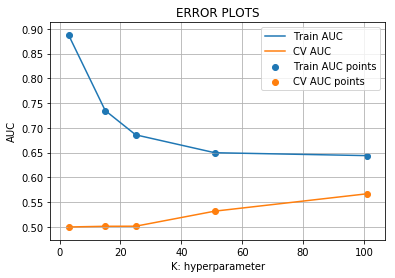

In [13]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

Random Search

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.009075      0.003395         0.222753        0.066185   
1       0.004782      0.000273         0.151917        0.003801   

  param_n_neighbors               params  split0_test_score  \
0                57  {'n_neighbors': 57}           0.522147   
1                53  {'n_neighbors': 53}           0.515829   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.565810           0.537612         0.541850        0.018081   
1           0.553966           0.539281         0.536348        0.015712   

   rank_test_score  split0_train_score  split1_train_score  \
0                9            0.646143            0.639872   
1               10            0.637388            0.648232   

   split2_train_score  mean_train_score  std_train_score  
0            0.670707          0.652241         0.013306  
1            0.668421          0.651347         0.012859  
KNeighborsClass

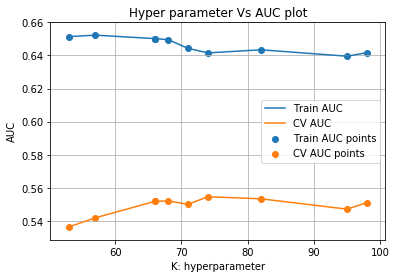

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,0.004782,0.000273,0.151917,0.003801,53,{'n_neighbors': 53},0.515829,0.553966,0.539281,0.536348,0.015712,10,0.637388,0.648232,0.668421,0.651347,0.012859
0,0.009075,0.003395,0.222753,0.066185,57,{'n_neighbors': 57},0.522147,0.565810,0.537612,0.541850,0.018081,9,0.646143,0.639872,0.670707,0.652241,0.013306
2,0.005101,0.000644,0.155934,0.001995,66,{'n_neighbors': 66},0.526823,0.572531,0.556090,0.551801,0.018911,4,0.638073,0.637069,0.675298,0.650147,0.017789
9,0.005290,0.000532,0.183493,0.020721,66,{'n_neighbors': 66},0.526823,0.572531,0.556090,0.551801,0.018911,4,0.638073,0.637069,0.675298,0.650147,0.017789
6,0.004411,0.000043,0.160725,0.004954,68,{'n_neighbors': 68},0.526212,0.571242,0.558879,0.552097,0.019004,3,0.634811,0.632784,0.680968,0.649521,0.022252


In [23]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

neigh = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':sp_randint(50, 100)}
clf = RandomizedSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr, y_train)
# print(clf.cv_results_)
results = pd.DataFrame.from_dict(clf.cv_results_)
print(results.head(2))
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')


plt.plot(K, cv_auc, label='CV AUC')


plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [15]:
best_k = 95

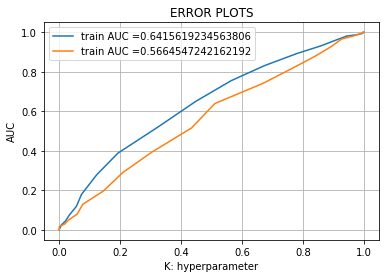

In [16]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_tr, y_train)

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [17]:

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [18]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3587697894990622 for threshold 0.842
Train confusion matrix
[[ 166  135]
 [ 679 1264]]
Test confusion matrix
[[108 113]
 [515 914]]


<h3>1.5.3 Appling KNN: AVG W2V featurization</h3>

In [0]:

with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:

avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))
print(avg_w2v_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 2244/2244 [00:00<00:00, 3111.93it/s]


2244
300
[ 5.33005407e-03  4.12416054e-02 -4.43186585e-02 -1.28163527e-01
  4.99318519e-04  9.72417111e-02 -3.48786000e+00  8.64229481e-02
  4.15002444e-03 -1.00114556e-01  1.91419430e-02 -2.86498963e-03
  1.39764550e-01 -8.59202074e-02 -3.45245310e-02  1.77790363e-02
  4.13685341e-02 -2.69475741e-02  7.55039926e-02 -1.45699583e-02
  4.80989267e-02 -4.08999341e-02  5.25691704e-03 -1.36482867e-02
 -1.58332539e-02 -8.24228252e-02  4.36251111e-02 -5.62350861e-02
 -5.72651156e-02 -6.21192444e-02 -2.05361665e-01 -1.08848329e-01
  1.06707444e-01  1.18229319e-01 -4.04386444e-02 -5.20993415e-02
 -6.06704363e-02 -1.60813489e-02 -3.54120633e-02 -4.81497407e-02
 -1.20012448e-01  1.27431464e-01 -2.52194667e-02 -1.69653133e-01
  2.95028007e-02 -5.06121756e-02  5.12632926e-02 -2.75269015e-02
 -1.88450630e-02 -9.17787052e-02 -8.68596000e-03 -1.05312482e-01
  2.06985361e-02 -3.02243593e-02  5.08290519e-02 -1.18690386e-01
  1.52117747e-01 -3.56924130e-02 -1.70493037e-02  1.00048272e-01
 -4.51816126e-02

In [0]:
avg_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

100%|████████████████████████████████████████████████████████████████████████████| 1106/1106 [00:00<00:00, 3380.66it/s]


In [0]:
avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

100%|████████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 3109.62it/s]


In [0]:
X_tr = hstack((avg_w2v_vectors_train, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm)).tocsr()
X_cr = hstack((avg_w2v_vectors_cv, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm)).tocsr()
X_te = hstack((avg_w2v_vectors_test, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(2244, 360) (2244,)
(1106, 360) (1106,)
(1650, 360) (1650,)


#### 1.5.3.1 Hyper parameter Tuning

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]


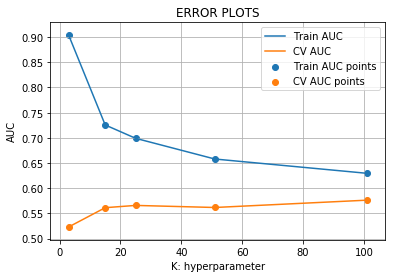

In [0]:
train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [0]:
best_k = 101

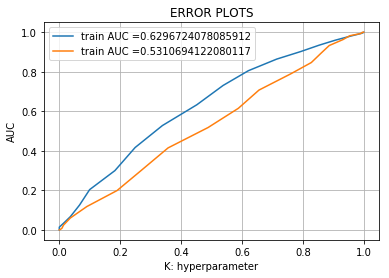

In [0]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_tr, y_train)
y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.34910907713694106 for threshold 0.881
Train confusion matrix
[[ 199  102]
 [ 917 1026]]
Test confusion matrix
[[113 108]
 [689 740]]
